In [1]:
#Imports
import sys
sys.path.append('../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

from datetime import datetime
import time as t

In [2]:
starttime = t.time()

data = dp.getXYdata_wXYerr('data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#for uncertainty band: (form noordermeer's thesis, p.)
delta_i = 3     # guessed value
v_i = (v_dat / np.tan(52*(np.pi/180)) * delta_i *(np.pi/180))

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (np.asarray(list(a)) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1_array = np.asarray(v_err1)
#Express as weights
weighdata = 1/(np.sqrt((v_err1**2)+(v_i**2)))

In [3]:
# Function for fitting only prefactors + halo's parameters + data thief
def g(r,M,rc,rho00,c,pref,gpref):
    return np.sqrt(nf.bh_v(r,M,load=True)**2 
                   + nf.h_v(r,rc,rho00,load=True)**2 
                   + c**2*nf.b_v(r,load=True)**2 
                   + pref**2*nf.d_thief(r)**2
                   + gpref**2*nf.g_thief(r)**2)
def nodm(r,M,c,pref,gpref):
    return np.sqrt(nf.bh_v(r,M,load=True)**2
                   + c**2*nf.b_v(r,load=True)**2 
                   + pref**2*nf.d_thief(r)**2
                   + gpref**2*nf.g_thief(r)**2)

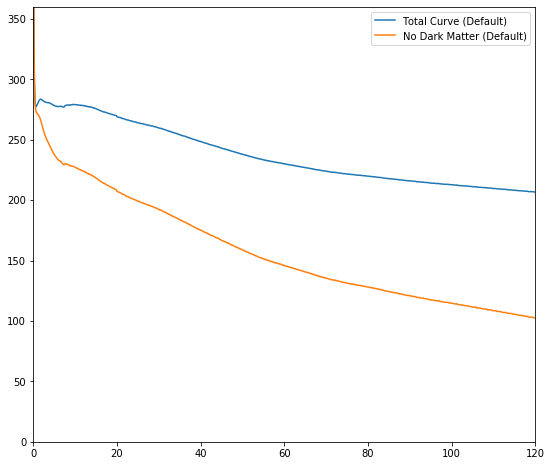

In [4]:
#Plot 
plt.figure(figsize=(9.0,8.0))

plt.xlim(0,120)
plt.ylim(0,360)

rval = np.arange(0.1,200,0.1)

plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')
plt.plot(rval,nodm(rval,nf.Mbh_def,1,1,1),label='No Dark Matter (Default)')

plt.legend()
#plt.savefig('Fitting_allcomponents_125kpc.png')
plt.show()

In [5]:
# Fit, using prefactors

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Black Hole
g_params.add('M', value=nf.Mbh_def, min=1.0e8) #Mass
#Halo
g_params.add('rc', value=nf.h_rc, min=0.1)   #Radius (magnitude)
g_params.add('rho00', value=nf.hrho00_c, min=0) #Density (halo)

#Bulge
g_params.add('c', value=1,min=0,max=100)          #Contributions should all add
#Disk
g_params.add('pref', value=1,min=0, max=100)

#gas
g_params.add('gpref', value=1,min=.8, max=1.2)

#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

In [6]:
#Define for plotting

bestg = g_fit.best_fit
delg = g_fit.eval_uncertainty()

In [7]:
print('Fit information for all-component fit, prefactor:')
g_fit

Fit information for all-component fit, prefactor:


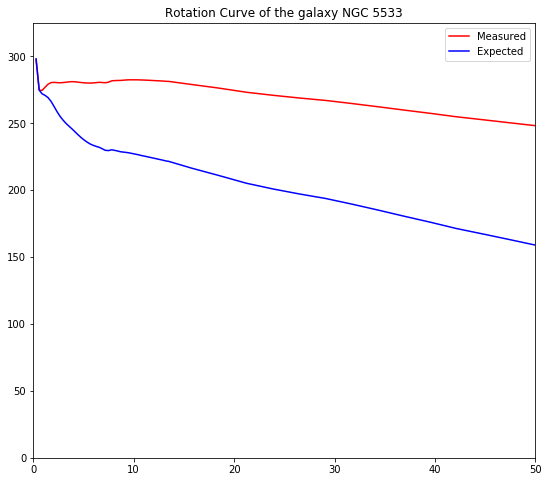

In [15]:
#Plot to 125kpc

plt.figure(figsize=(9.0,8.0))
plt.xlim(0,50)
plt.ylim(0,325)

plt.title("Rotation Curve of the galaxy NGC 5533")
plt.plot(r_dat,bestg,'r-',label='Measured')
plt.plot(r_dat,nodm(r_dat,nf.Mbh_def,1,1,1), 'blue', label='Expected')

plt.legend()
#plt.savefig('Fitting_allcomponents_25kpc.png')
plt.show()